# Flood Duration
Tralala

In [1]:
%run setup.ipynb
data_dir = Path('../data' )
output_dir = Path('../output') 

In [2]:
hourly_data = xr.open_dataset(data_dir / 'SL_hourly_data.nc')
hourly_data.close()

In [3]:
hourly_data

<xarray.Dataset>
Dimensions:               (time: 359377, record_id: 8)
Coordinates:
  * time                  (time) datetime64[ns] 1983-01-01 ... 2023-12-31
  * record_id             (record_id) int64 52 60 552 59 57 61 58 50
Data variables: (12/14)
    sea_level             (record_id, time) float32 ...
    lat                   (record_id) float32 ...
    lon                   (record_id) float32 ...
    station_name          (record_id) <U16 ...
    station_country       (record_id) <U30 ...
    station_country_code  (record_id) float32 ...
    ...                    ...
    ssc_id                (record_id) <U4 ...
    last_rq_date          (record_id) datetime64[ns] ...
    MHHW                  (record_id) float64 ...
    MSL                   (record_id) float64 ...
    sea_level_MHHW        (record_id, time) float64 ...
    year_storm            (time) int64 ...
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2024-08-19T14:27:33Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

In [4]:
# thresholds = [30,]

In [5]:
# flood_hour = (hourly_data.sea_level_MHHW.values > thresholds[:,None])
flood_hour = (hourly_data.sea_level_MHHW.values > 30)
flood_hour
flood_hour = np.transpose(flood_hour)

# turn flood_hour into a pandas dataframe with time as index and station as columns

In [6]:
flood_hour_df = pd.DataFrame(flood_hour, index = hourly_data.time.values, columns = hourly_data.record_id.values)

flood_hour_df

,52,60,552,59,57,61,58,50
1983-01-01 00:00:00.000000,False,False,False,False,False,False,False,False
1983-01-01 01:00:00.028800,False,False,False,False,False,False,False,False
1983-01-01 01:59:59.971200,False,False,False,False,False,False,False,False
1983-01-01 03:00:00.000000,False,False,False,False,False,False,False,False
1983-01-01 04:00:00.028800,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
2023-12-30 19:59:59.971200,False,False,False,False,False,False,False,False
2023-12-30 21:00:00.000000,False,False,False,False,False,False,False,False
2023-12-30 22:00:00.028800,False,False,False,False,False,False,False,False
2023-12-30 22:59:59.971200,False,False,False,False,False,False,False,False


In [8]:
# Find indices of flood events, and the duration of each event for record id = 57
# Initialize a dictionary to store the durations
flood_durations = {}


df_flood = flood_hour_df 

# Loop through each sensor column
for column in flood_hour_df.columns:
    flood_durations[column] = []
    
    # Find the indices where flooding starts and ends
    flood_events = df_flood[column].ne(df_flood[column].shift()).cumsum()
    
    # Group by the flood event indices, filtering out False events
    for event_id, group in df_flood.groupby(flood_events):
        if group[column].iloc[0]:  # Only consider True (flood) events
            start_time = group.index.min()
            end_time = group.index.max()
            duration = end_time - start_time 
            # round to nearest hour
            duration = np.round(duration.total_seconds() / 3600) + 1
            flood_durations[column].append((start_time, duration))




In [58]:
# make dataframe from dictionary
# Assuming flood_durations and hourly_data are already defined

# Initialize an empty list to store DataArrays
data_arrays = []

# Loop through each record_id and create a DataArray
for record_id in hourly_data.record_id.values:
    flood_durations_df = pd.DataFrame(flood_durations[record_id])
    flood_durations_df.columns = ['time', 'duration']
    
    flood_durations_da = xr.DataArray(
        flood_durations_df.duration.values,
        dims=['time'],
        coords={'time': flood_durations_df.time.values, 'record_id': record_id}
    )
    
    data_arrays.append(flood_durations_da)

# Combine all DataArrays into a single Dataset
flood_durations_ds = xr.concat(data_arrays, dim='record_id')

# Convert to Dataset
flood_durations_ds = flood_durations_ds.to_dataset(name='duration')

flood_durations_ds


<xarray.Dataset>
Dimensions:    (time: 2277, record_id: 8)
Coordinates:
  * time       (time) datetime64[ns] 1983-01-01T15:00:00 ... 2023-12-25T13:00...
  * record_id  (record_id) int64 52 60 552 59 57 61 58 50
Data variables:
    duration   (record_id, time) float64 nan nan nan nan 2.0 ... nan nan nan nan

In [60]:
# make storm time by shifting time by 4 months, such that May 1st is the start of the storm season
# Convert the time values to pandas DatetimeIndex
time_values = pd.to_datetime(flood_durations_ds.time.values)

# Jan 1 should be the equivalent of May 1
shifted_time_values = time_values + pd.DateOffset(months=4)

#remove anything in 1982
shifted_time_values = shifted_time_values[shifted_time_values.year != 1982]


# Assign the shifted time values back to the dataset
flood_durations_ds['time'] = shifted_time_values

flood_durations_ds

<xarray.Dataset>
Dimensions:    (time: 2277, record_id: 8)
Coordinates:
  * time       (time) datetime64[ns] 1983-01-01T15:00:00 ... 2023-12-25T13:00...
  * record_id  (record_id) int64 52 60 552 59 57 61 58 50
Data variables:
    duration   (record_id, time) float64 nan nan nan nan 2.0 ... nan nan nan nan

In [61]:
# scatterplot flood duration vs year

# make figure size small
plt.figure(figsize=(6,6))

adjusted_heatmap_palette = sns.color_palette("Blues", n_colors=5).as_hex()[1:]  # Skip the lightest shade



sns.scatterplot(data=flood_durations_ds[0], x='storm_year', y='storm_month', size='duration', palette=adjusted_heatmap_palette, hue = 'duration',legend=False)

KeyError: 0

<Figure size 600x600 with 0 Axes>

<Axes: xlabel='storm_year', ylabel='storm_month'>

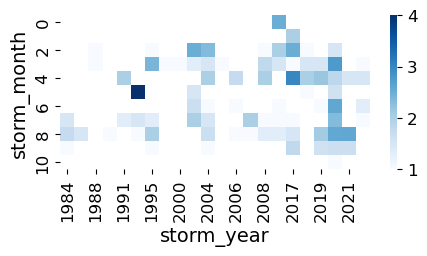

In [27]:
# make pcolormesh plot
plt.figure(figsize=(5,2))
sns.heatmap(flood_durations_df.pivot_table(index='storm_month', columns='storm_year', values='duration_57', aggfunc='mean'), cmap='Blues')

In [94]:
# make dataframe of flood durations
flood_durations_df = pd.DataFrame(flood_durations[57], columns = ['start_time', 'end_time', 'duration'])

# remove rows with duration = 0
flood_durations_df = flood_durations_df[flood_durations_df.duration != 0]

# group by year
flood_durations_df['year'] = flood_durations_df.start_time.dt.year
flood_durations_df['month'] = flood_durations_df.start_time.dt.month

# summary statistics, average duration of flood events by year
year_median = flood_durations_df.groupby('year').duration.median()
year_mean = flood_durations_df.groupby('year').duration.mean()
year_max = flood_durations_df.groupby('year').duration.max()


year_summary = pd.DataFrame({'median': year_median, 'mean': year_mean, 'max': year_max})

# summary statistics, average duration of flood events by month
month_median = flood_durations_df.groupby('month').duration.median()
month_mean = flood_durations_df.groupby('month').duration.mean()
month_max = flood_durations_df.groupby('month').duration.max()

month_summary = pd.DataFrame({'median': month_median, 'mean': month_mean, 'max': month_max})

/Users/juliafiedler/anaconda3/envs/SLI39/lib/python3.9/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


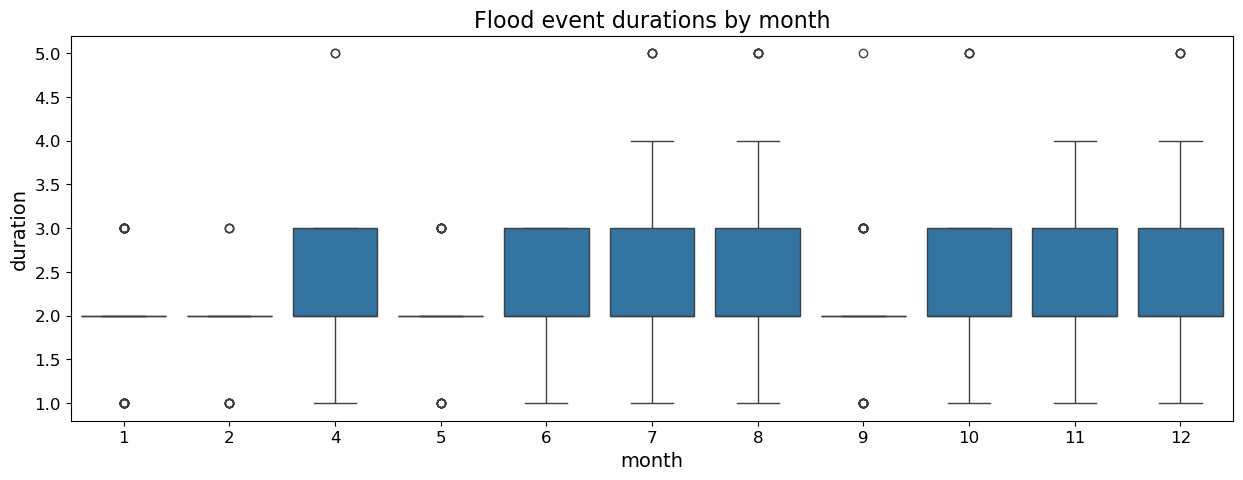

In [95]:
# plt.scatter(year_summary.index, year_summary['mean'], label = 'mean')
# plt.scatter(year_summary.index, year_summary['median'], label = 'median')
# plt.plot(year_summary.index, year_summary['max'], label = 'max')

# make whisker plot of flood event durations by year
plt.figure(figsize = (15, 5))
sns.boxplot(data = flood_durations_df, x = 'month', y = 'duration')
plt.title('Flood event durations by month')
plt.show()

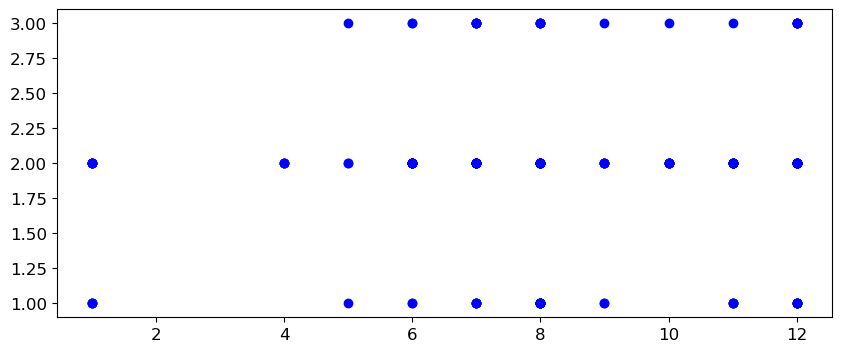

In [69]:
# plot flood events by month and duration
plt.figure()
# plt.plot(month_summary.index, month_summary['mean'], label = 'mean')
plt.scatter(flood_durations_df.month, flood_durations_df.duration, color = 'blue')

In [75]:
# sum flood_hour_df by day
flood_hours_in_day_df = flood_hour_df.resample('D').sum()

In [85]:
flood_hours_in_day_df
flood_hours_in_day_df_57 = flood_hours_in_day_df[57]

flood_hours_in_day_df_57

1983-01-01    0
1983-01-02    0
1983-01-03    0
1983-01-04    0
1983-01-05    0
             ..
2023-12-27    0
2023-12-28    0
2023-12-29    0
2023-12-30    0
2023-12-31    0
Freq: D, Name: 57, Length: 14975, dtype: int64

<BarContainer object of 14975 artists>

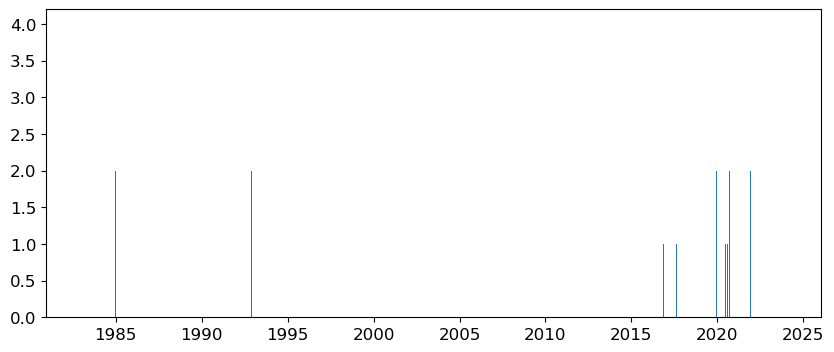

There will be more. This is a placeholder.